In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine
import warnings 
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [126]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
hp_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

### lets look at the target distribution

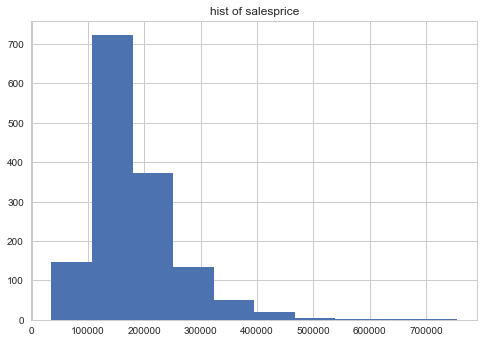

In [127]:
plt.hist(hp_df['saleprice'])
plt.title("hist of salesprice")
plt.show()

In [128]:
hp_df.corr().loc[:,"saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

In [129]:
pd.isnull(hp_df).sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
bsmtqual           37
bsmtcond           37
bsmtexposure       38
bsmtfintype1       37
bsmtfinsf1          0
bsmtfintype2       38
bsmtfinsf2          0
bsmtunfsf           0
totalbsmtsf         0
heating             0
heatingqc           0
centralair          0
electrical          1
firstflrsf          0
secondflrsf         0
lowqualfin

### ignore missing values since will not use in model

In [130]:
# identify non numeric columns

non_numeric_columns = hp_df.select_dtypes(['object']).columns
print(non_numeric_columns)

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')


In [ ]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(hp_df.groupby(column)["saleprice"].mean().index, hp_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

 ### convert to dummy 

In [119]:
hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
hp_df = pd.concat([hp_df,pd.get_dummies(hp_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(hp_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(hp_df.street, prefix="street", drop_first=True).columns)

### Load model

In [122]:
X = hp_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = hp_df.saleprice

In [123]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Wed, 04 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:37:04   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_FV  8362.5046   4562.459      1.833      0.067    -587.226    1.73e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RH  4473.4855   5282.272      0.847      0.397   -5888.232    1.48e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RL  9521.9520   4240.253      2.246      0.025    1204.261    1.78e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
mszoning_RM  3015.9298   4296.911      0.702      0.483   -5412.902    1.14e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
street_Pave    50.3459   5430.500      0.009      0.993   -1.06e+04    1.07e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     3.93e+37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.78e-66. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""